In [1]:
!pip install opendatasets


In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews")

Skipping, found downloaded files in "./mcdonalds-store-reviews" (use force=True to force download)


In [3]:
import pandas as pd
from tqdm import tqdm
import re

In [4]:
data = pd.read_csv("/content/mcdonalds-store-reviews/McDonald_s_Reviews.csv", encoding='latin1')

In [5]:
data.shape

(33396, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


In [7]:
# Ambil kolom penting-penting aja walaupun yang dipake cuma kolom riview
data = data[['store_name', 'review', 'rating']].dropna(subset=['review'])

# Ambil 50 data sebagai sampel takutnya tokennya ga cukup
data = data.head(50)

print(f"Jumlah data dipakai: {len(data)}")
data.head()


Jumlah data dipakai: 50


,store_name,review,rating
0,McDonald's,Why does it look like someone spit on my food?...,1 star
1,McDonald's,It'd McDonalds. It is what it is as far as the...,4 stars
2,McDonald's,Made a mobile order got to the speaker and che...,1 star
3,McDonald's,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,McDonald's,"I repeat my order 3 times in the drive thru, a...",1 star


In [8]:
def preprocess_text(text):
    text = text.lower()                          # huruf kecil semua
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # hapus URL
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)   # hapus simbol
    text = re.sub(r"\s+", " ", text).strip()     # hapus spasi ganda
    return text

data['cleaned_review'] = data['review'].apply(preprocess_text)
data.head()


,store_name,review,rating,cleaned_review
0,McDonald's,Why does it look like someone spit on my food?...,1 star,why does it look like someone spit on my food ...
1,McDonald's,It'd McDonalds. It is what it is as far as the...,4 stars,itd mcdonalds it is what it is as far as the f...
2,McDonald's,Made a mobile order got to the speaker and che...,1 star,made a mobile order got to the speaker and che...
3,McDonald's,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,my mc crispy chicken sandwich was customer ser...
4,McDonald's,"I repeat my order 3 times in the drive thru, a...",1 star,i repeat my order 3 times in the drive thru an...


In [9]:
!pip install langchain_community
!pip install replicate

In [10]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('REPLICATE_API_TOKEN')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [11]:
import replicate
import time

tqdm.pandas()

def analyze_batch(reviews):
    """
    Mengirim 10 review sekaligus ke IBM Granite untuk klasifikasi multi-aspek.
    """
    joined_reviews = "\n\n".join([f"Review {i+1}: {r}" for i, r in enumerate(reviews)])
    prompt = f"""
    You are a sentiment analyst for McDonald's customer reviews.

    Analyze the following reviews and classify the sentiment for each aspect:
    - Food Quality
    - Service
    - Speed
    - Cleanliness
    - Price
    - Atmosphere

    For each review, respond clearly as:
    Review <number>:
    Aspect: <aspect> | Sentiment: <Positive/Neutral/Negative>

    Reviews:
    {joined_reviews}
    """

    try:
        output = replicate.run(
            "ibm-granite/granite-3.3-8b-instruct",
            input={"prompt": prompt}
        )
        return str(output).strip()
    except Exception as e:
        return f"Error: {e}"



In [32]:
batch_size = 10
batch_outputs = []

# Add the first 10 cleaned reviews to the batch_results_df
# Assuming 'data' DataFrame with 'cleaned_review' column is available from previous cells
cleaned_reviews_for_batch = data['cleaned_review'].iloc[:batch_size].tolist()


for i in tqdm(range(0, len(data), batch_size)):
    batch = data['cleaned_review'].iloc[i:i+batch_size].tolist()
    result = analyze_batch(batch)
    batch_outputs.append({
        "batch_index": i//batch_size + 1,
        "reviews_in_batch": len(batch),
        "cleaned_reviews": batch, # Add the cleaned reviews list to the dictionary
        "granite_output": result
    })
    time.sleep(10)

# Simpan hasil batch di DataFrame baru
batch_result_df = pd.DataFrame(batch_outputs)
batch_result_df.to_csv("granite_batch_results.csv", index=False)
print("✅ Hasil batch disimpan ke granite_batch_results.csv")

100%|██████████| 5/5 [01:14<00:00, 14.86s/it]

✅ Hasil batch disimpan ke granite_batch_results.csv


In [22]:
# Reload the original data if it was overwritten
# Assuming the original data is still available at "/content/mcdonalds-store-reviews/McDonald_s_Reviews.csv"
original_data = pd.read_csv("/content/mcdonalds-store-reviews/McDonald_s_Reviews.csv", encoding='latin1')
original_data = original_data[['store_name', 'review', 'rating']].dropna(subset=['review'])
original_data = original_data.tail(10) # Keep the same 50 data points
original_data['cleaned_review'] = original_data['review'].apply(preprocess_text)

# Load the batch results
batch_results_df = pd.read_csv("granite_batch_results.csv")

# Merge the batch results with the original data
# Assuming the order of reviews in batch_results_df corresponds to the order in original_data.
# A more robust approach would be to include an identifier in the batch results.
data_with_batch_results = original_data.copy()
data_with_batch_results['granite_batch_output'] = batch_results_df['granite_output']


# Function to ask Granite to summarize with retry mechanism
def summarize_review(review_text, retries=5, backoff_factor=3): # Increased retries and backoff factor
    """
    Summarize the following McDonald's store review in one short sentence,
    highlighting the main opinion (positive, neutral, or negative)
    and any key aspects (service, food quality, speed, etc).
    Includes retry with exponential backoff.
    """
    prompt = f"""
    Summarize the following McDonald's store review in one short sentence,
    highlighting the main opinion (positive, neutral, or negative)
    and any key aspects (service, food quality, speed, etc):

    Review: "{review_text}"
    """
    for attempt in range(retries):
        try:
            output = replicate.run(
                "ibm-granite/granite-3.3-8b-instruct",
                input={"prompt": prompt}
            )
            return "".join(output)
        except replicate.exceptions.ReplicateError as e:
            if e.status == 429 and attempt < retries - 1:
                sleep_time = backoff_factor ** attempt + 2 # Increased base sleep time
                print(f"Rate limited (429) during summarization. Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                return f"Error: {e}"
        except Exception as e:
            return f"Error: {e}"
    return "Error: Max retries exceeded for summarization"


# Buat kolom summary baru
summaries = []
for r in tqdm(data_with_batch_results["cleaned_review"][:20]): # ambil 20 dulu biar hemat limit
    summaries.append(summarize_review(r))
    time.sleep(3) # Added sleep time between summarization calls

data_with_batch_results["summary"] = summaries


# Apply preprocess_text to the summary column
data_with_batch_results['summary'] = data_with_batch_results['summary'].apply(preprocess_text)


# Simpan hasilnya
data_with_batch_results.to_csv("granite_summary_results.csv", index=False)
print("✅ Summary selesai. File disimpan sebagai granite_summary_results.csv.")

 10%|█         | 1/10 [00:03<00:32,  3.63s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 20%|██        | 2/10 [00:15<01:06,  8.33s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 30%|███       | 3/10 [00:26<01:09,  9.86s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 40%|████      | 4/10 [00:38<01:04, 10.68s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 50%|█████     | 5/10 [00:51<00:56, 11.32s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 60%|██████    | 6/10 [01:03<00:45, 11.46s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 70%|███████   | 7/10 [01:14<00:34, 11.53s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 80%|████████  | 8/10 [01:26<00:23, 11.59s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


 90%|█████████ | 9/10 [01:38<00:11, 11.64s/it]

Rate limited (429) during summarization. Retrying in 3 seconds...
Rate limited (429) during summarization. Retrying in 5 seconds...


100%|██████████| 10/10 [01:49<00:00, 11.00s/it]

✅ Summary selesai. File disimpan sebagai granite_summary_results.csv.


In [33]:
import pandas as pd

klasifikasi = pd.read_csv("/content/granite_batch_results.csv")
display(klasifikasi)

,batch_index,reviews_in_batch,cleaned_reviews,granite_output
0,1,10,['why does it look like someone spit on my foo...,"['', '', 'Review 1:\nAspect: Food Quality | Se..."
1,2,10,"['worst mcdonald', 'we stopped by for a quick ...","['', '', 'Review 1:\nAspect: Food Quality | Se..."
2,3,10,['cant believe experience with order taker wen...,"['', '', 'Review 1:\nAspect: Service | Sentime..."
3,4,10,['sarcasm this was exactly what i ordered a 20...,"['', '', 'Review 1:\nAspect: Service | Sentime..."
4,5,10,['if you didnt take 15 minutes to take a few o...,"['', '', 'Review 1:\nAspect: Speed | Sentiment..."


In [34]:
rangkuman = pd.read_csv("/content/granite_summary_results.csv")
display(rangkuman)

,store_name,review,rating,cleaned_review,granite_batch_output,summary
0,McDonald's,Great in fast food ï¿½ï¿½ï¿,5 stars,great in fast food,NaN,the review expresses a positive opinion about ...
1,McDonald's,"Excellent location and very good atmosphere, e...",5 stars,excellent location and very good atmosphere ex...,NaN,the review expresses a positive opinion praisi...
2,McDonald's,All very good food attention,5 stars,all very good food attention,NaN,the review expresses a positive opinion highli...
3,McDonald's,Quiet open the local January 1.,4 stars,quiet open the local january 1,NaN,the review quiet open the local january 1 expr...
4,McDonald's,Very. Well,5 stars,very well,NaN,the review expresses a positive opinion highli...
5,McDonald's,They treated me very badly.,1 star,they treated me very badly,NaN,the main opinion of the review is negative as ...
6,McDonald's,The service is very good,5 stars,the service is very good,NaN,the review expresses a positive opinion about ...
7,McDonald's,To remove hunger is enough,4 stars,to remove hunger is enough,NaN,the review humorously implies satisfaction sug...
8,McDonald's,"It's good, but lately it has become very expen...",5 stars,its good but lately it has become very expensive,NaN,the review expresses a predominantly positive ...
9,McDonald's,they took good care of me,5 stars,they took good care of me,NaN,the review expresses a positive sentiment high...


# Task
Analyze sentiments from "granite_batch_results.csv"

## Load data

### Subtask:
Load the `granite_batch_results.csv` file into a pandas DataFrame.


**Reasoning**:
The subtask is to load the `granite_batch_results.csv` file into a pandas DataFrame. The previous code blocks have already imported pandas. I will now read the CSV file and display the head and info of the dataframe to verify the loading.



In [35]:
batch_results_df = pd.read_csv("/content/granite_batch_results.csv")
display(batch_results_df.head())
display(batch_results_df.info())

,batch_index,reviews_in_batch,cleaned_reviews,granite_output
0,1,10,['why does it look like someone spit on my foo...,"['', '', 'Review 1:\nAspect: Food Quality | Se..."
1,2,10,"['worst mcdonald', 'we stopped by for a quick ...","['', '', 'Review 1:\nAspect: Food Quality | Se..."
2,3,10,['cant believe experience with order taker wen...,"['', '', 'Review 1:\nAspect: Service | Sentime..."
3,4,10,['sarcasm this was exactly what i ordered a 20...,"['', '', 'Review 1:\nAspect: Service | Sentime..."
4,5,10,['if you didnt take 15 minutes to take a few o...,"['', '', 'Review 1:\nAspect: Speed | Sentiment..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   batch_index       5 non-null      int64 
 1   reviews_in_batch  5 non-null      int64 
 2   cleaned_reviews   5 non-null      object
 3   granite_output    5 non-null      object
dtypes: int64(2), object(2)
memory usage: 292.0+ bytes


None

## Parse llm output

### Subtask:
Create a function to parse the text in the `granite_output` column to extract the sentiment for each aspect (Food Quality, Service, Speed, Cleanliness, Price, Atmosphere) for each review within the batch. Handle potential errors or variations in the LLM output format.


**Reasoning**:
Define the function `parse_granite_output` to extract sentiment information from the `granite_output` column.



In [36]:
def parse_granite_output(granite_output_string):
    """
    Parses the text in the granite_output column to extract sentiment for each aspect.

    Args:
        granite_output_string: The string content of the 'granite_output' column.

    Returns:
        A dictionary containing the parsed sentiments for each review and aspect.
    """
    parsed_sentiments = {}
    if isinstance(granite_output_string, str) and "Error:" not in granite_output_string:
        # Split into individual reviews
        review_sections = re.split(r"Review (\d+):", granite_output_string)
        # The first element is usually empty or contains introductory text, skip it
        for i in range(1, len(review_sections), 2):
            review_number = review_sections[i].strip()
            review_content = review_sections[i+1].strip()
            parsed_sentiments[f'Review {review_number}'] = {}
            # Split review content into lines and parse aspects
            for line in review_content.split('\n'):
                line = line.strip()
                if line.startswith("Aspect:"):
                    parts = line.split('|')
                    if len(parts) == 2:
                        aspect_part = parts[0].replace("Aspect:", "").strip()
                        sentiment_part = parts[1].replace("Sentiment:", "").strip()
                        parsed_sentiments[f'Review {review_number}'][aspect_part] = sentiment_part
    return parsed_sentiments

# Apply the function to the 'granite_output' column
batch_results_df['parsed_sentiments'] = batch_results_df['granite_output'].apply(parse_granite_output)

# Display the updated DataFrame with the new column
display(batch_results_df.head())

,batch_index,reviews_in_batch,cleaned_reviews,granite_output,parsed_sentiments
0,1,10,['why does it look like someone spit on my foo...,"['', '', 'Review 1:\nAspect: Food Quality | Se...","{'Review 1': {}, 'Review 2': {}, 'Review 3': {..."
1,2,10,"['worst mcdonald', 'we stopped by for a quick ...","['', '', 'Review 1:\nAspect: Food Quality | Se...","{'Review 1': {}, 'Review 2': {}, 'Review 3': {..."
2,3,10,['cant believe experience with order taker wen...,"['', '', 'Review 1:\nAspect: Service | Sentime...","{'Review 1': {}, 'Review 2': {}, 'Review 3': {..."
3,4,10,['sarcasm this was exactly what i ordered a 20...,"['', '', 'Review 1:\nAspect: Service | Sentime...","{'Review 1': {}, 'Review 2': {}, 'Review 3': {..."
4,5,10,['if you didnt take 15 minutes to take a few o...,"['', '', 'Review 1:\nAspect: Speed | Sentiment...","{'Review 1': {}, 'Review 2': {}, 'Review 3': {..."


**Reasoning**:
The parsing logic needs to be refined to correctly handle the input string format, which appears to be a string representation of a list containing empty strings and the desired output. I will modify the parsing function to account for this.



In [37]:
def parse_granite_output(granite_output_string):
    """
    Parses the text in the granite_output column to extract sentiment for each aspect.

    Args:
        granite_output_string: The string content of the 'granite_output' column.

    Returns:
        A dictionary containing the parsed sentiments for each review and aspect.
    """
    parsed_sentiments = {}
    if isinstance(granite_output_string, str) and "Error:" not in granite_output_string:
        # Attempt to evaluate the string as a list, handling potential errors
        try:
            # Safely evaluate the string as a list
            output_list = eval(granite_output_string)
            # Find the element that looks like the actual review analysis
            analysis_string = next((item for item in output_list if isinstance(item, str) and "Review 1:" in item), None)

            if analysis_string:
                # Split into individual reviews
                review_sections = re.split(r"Review (\d+):", analysis_string)
                # The first element is usually empty or contains introductory text, skip it
                for i in range(1, len(review_sections), 2):
                    review_number = review_sections[i].strip()
                    review_content = review_sections[i+1].strip()
                    parsed_sentiments[f'Review {review_number}'] = {}
                    # Split review content into lines and parse aspects
                    for line in review_content.split('\n'):
                        line = line.strip()
                        # Modified parsing logic to correctly capture Aspect and Sentiment
                        if line.startswith("Aspect:"):
                            parts = line.split('|')
                            if len(parts) == 2:
                                aspect_part = parts[0].replace("Aspect:", "").strip()
                                sentiment_part = parts[1].replace("Sentiment:", "").strip()
                                # Ensure both aspect and sentiment are not empty before adding
                                if aspect_part and sentiment_part:
                                    parsed_sentiments[f'Review {review_number}'][aspect_part] = sentiment_part
        except (SyntaxError, TypeError, NameError) as e:
            # Handle cases where the string is not a valid list representation
            print(f"Error evaluating string: {e} for input: {granite_output_string[:100]}...")
            pass # Return empty dictionary for this case

    return parsed_sentiments

# Apply the updated function to the 'granite_output' column
batch_results_df['parsed_sentiments'] = batch_results_df['granite_output'].apply(parse_granite_output)

# Display the updated DataFrame with the new column
display(batch_results_df.head())

,batch_index,reviews_in_batch,cleaned_reviews,granite_output,parsed_sentiments
0,1,10,['why does it look like someone spit on my foo...,"['', '', 'Review 1:\nAspect: Food Quality | Se...","{'Review 1': {'Food Quality': 'Negative', 'Ser..."
1,2,10,"['worst mcdonald', 'we stopped by for a quick ...","['', '', 'Review 1:\nAspect: Food Quality | Se...","{'Review 1': {'Food Quality': 'Negative', 'Ser..."
2,3,10,['cant believe experience with order taker wen...,"['', '', 'Review 1:\nAspect: Service | Sentime...","{'Review 1': {'Service': 'Negative'}, 'Review ..."
3,4,10,['sarcasm this was exactly what i ordered a 20...,"['', '', 'Review 1:\nAspect: Service | Sentime...","{'Review 1': {'Service': 'Negative', 'Speed': ..."
4,5,10,['if you didnt take 15 minutes to take a few o...,"['', '', 'Review 1:\nAspect: Speed | Sentiment...","{'Review 1': {'Speed': 'Negative'}, 'Review 2'..."


## Structure sentiment data

### Subtask:
Apply the parsing function to the DataFrame and structure the extracted sentiments into a new DataFrame with columns for each aspect and review identifier.


**Reasoning**:
Initialize an empty list to store the structured sentiment data and iterate through each row of the batch_results_df DataFrame to extract and structure the sentiments into a list of dictionaries. Then create a new DataFrame from this list and display its head.



In [38]:
structured_sentiments_list = []

for index, row in batch_results_df.iterrows():
    batch_index = row['batch_index']
    parsed_sentiments = row['parsed_sentiments']

    if isinstance(parsed_sentiments, dict):
        for review_id, aspects_sentiments in parsed_sentiments.items():
            for aspect, sentiment in aspects_sentiments.items():
                structured_sentiments_list.append({
                    'batch_index': batch_index,
                    'review_id_in_batch': review_id,
                    'aspect': aspect,
                    'sentiment': sentiment
                })

structured_sentiments_df = pd.DataFrame(structured_sentiments_list)
display(structured_sentiments_df.head())

,batch_index,review_id_in_batch,aspect,sentiment
0,1,Review 1,Food Quality,Negative
1,1,Review 1,Service,Neutral
2,1,Review 1,Speed,Not mentioned
3,1,Review 1,Cleanliness,Not mentioned
4,1,Review 1,Price,Not mentioned


## Analyze aggregated sentiments

### Subtask:
Aggregate the sentiment data to calculate the distribution of Positive, Neutral, and Negative sentiments for each aspect across all reviews.


**Reasoning**:
Aggregate the sentiment data by grouping by aspect and counting the sentiment values to get the distribution for each aspect.



In [39]:
sentiment_distribution = structured_sentiments_df.groupby('aspect')['sentiment'].value_counts().unstack(fill_value=0)
display(sentiment_distribution)

sentiment,Negative,Negative (burnt food),Negative (dirty tables),Negative (failed to deliver food),Negative (ignored customer complaint),Negative (incomplete information),"Negative (incorrect condiments, uneven portion sizes)",Negative (long wait time),"Negative (long wait times, slow service)",Negative (missed a food item),...,"Negative (slow service, long line)",Negative (unpleasant experience),"Negative (wrong order, missing parts)",Neutral,Neutral (Incomplete review),Neutral (not mentioned),"Neutral (though implied, as the review describes poor customer service and mismanagement of the drive-thru line)",Not mentioned,Positive,Sent
aspect,,,,,,,,,,,,,,,,,,,,,
Accuracy,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atmosphere,3,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,10,1,0
Cleanliness,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,13,1,0
Drink Quality,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Employee Attitude,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Food Accuracy,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Food Quality,7,1,0,0,0,0,1,0,0,1,...,0,0,1,1,0,0,0,2,3,0
Ice Cream Availability,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Management,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Visualize sentiments

### Subtask:
Create visualizations (e.g., bar charts) to show the sentiment distribution for each aspect.


**Reasoning**:
Visualize the sentiment distribution for each aspect using bar charts.



/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


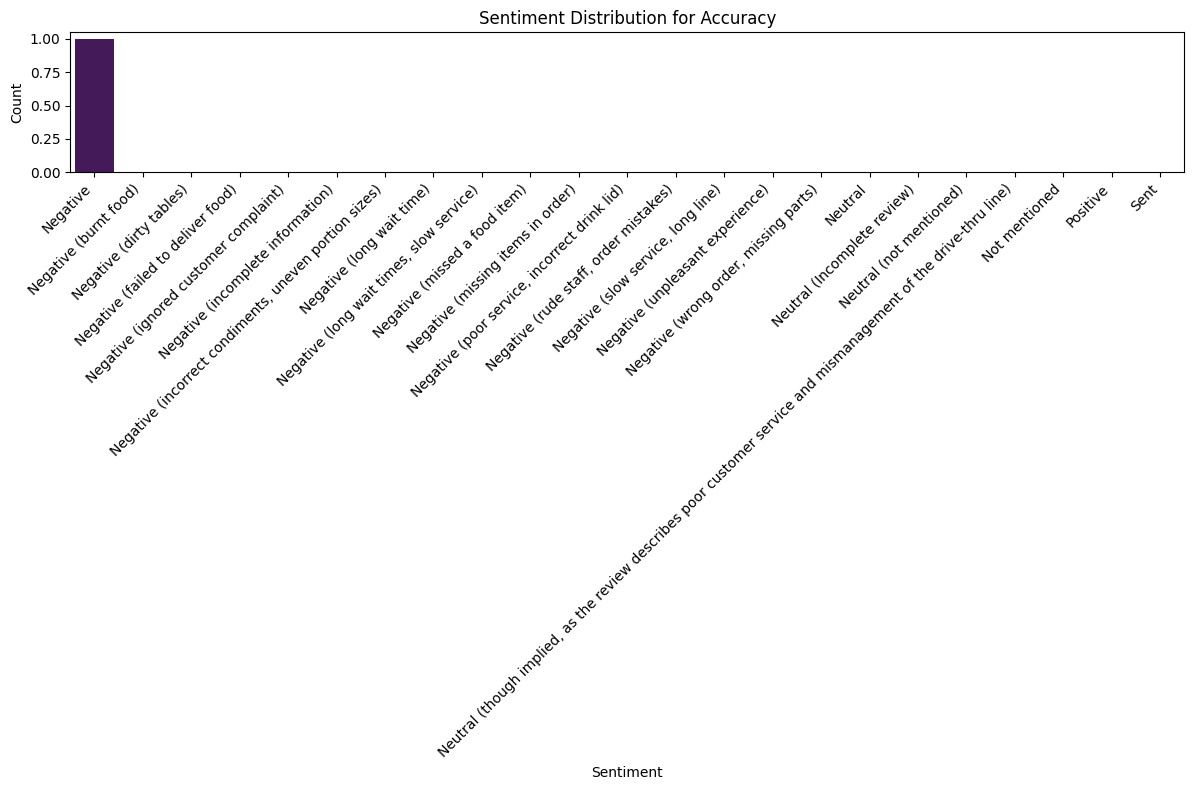

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


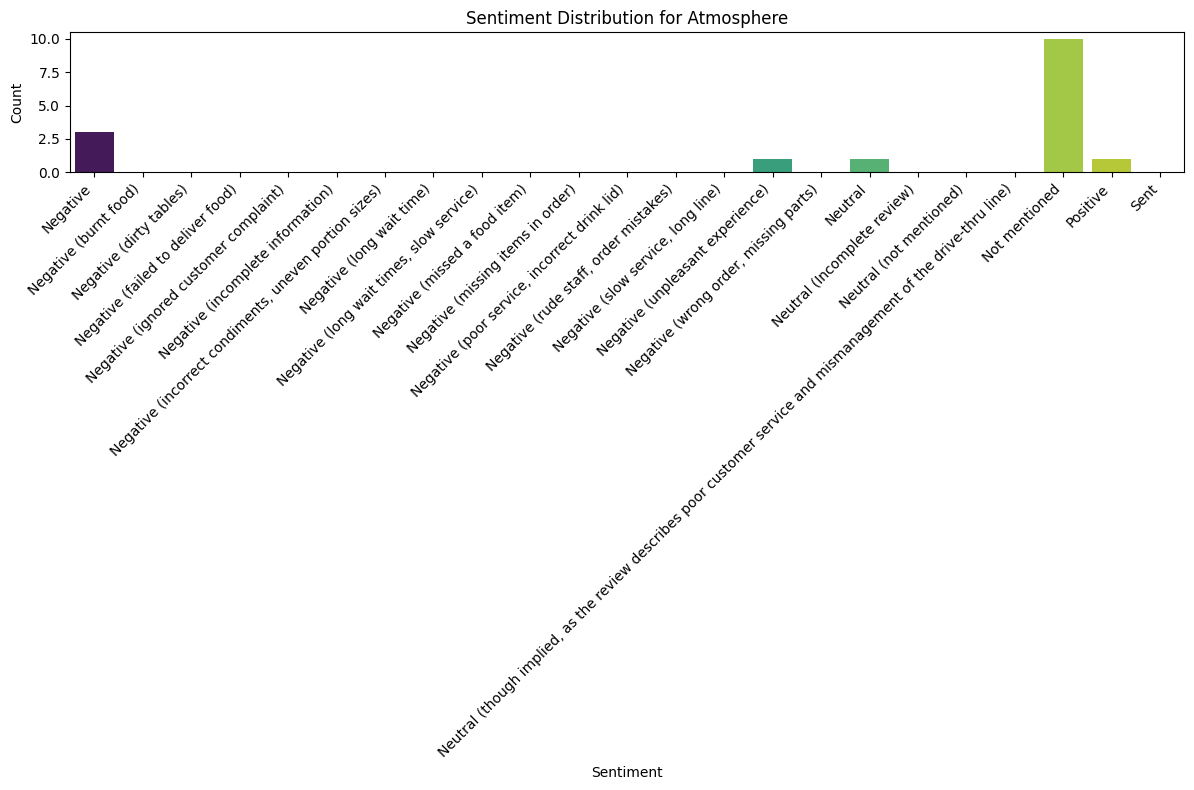

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


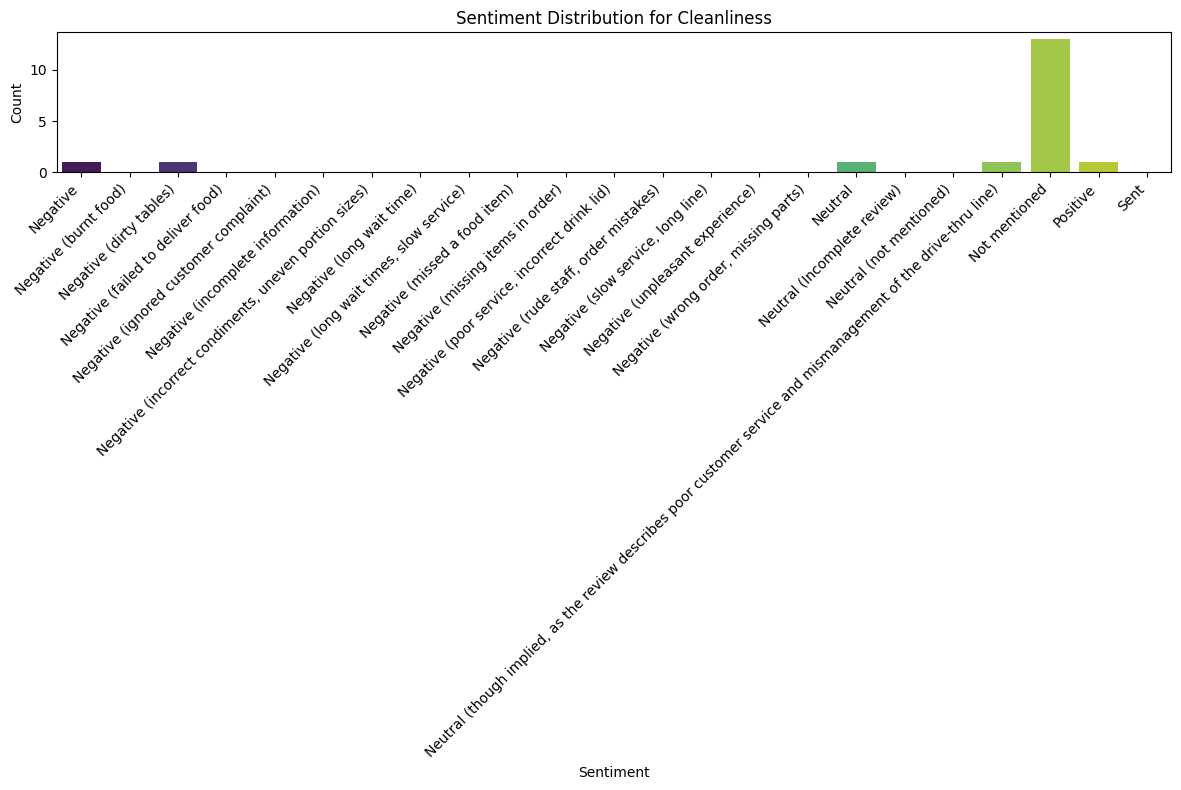

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


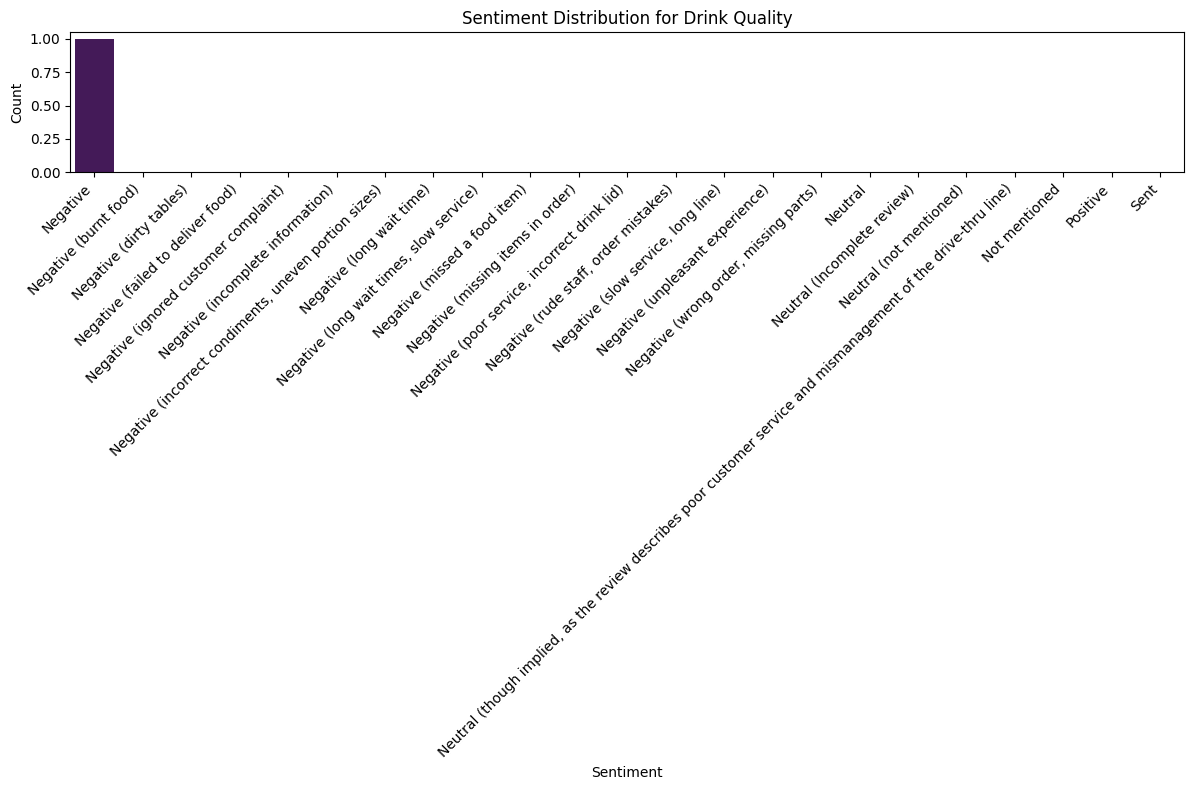

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


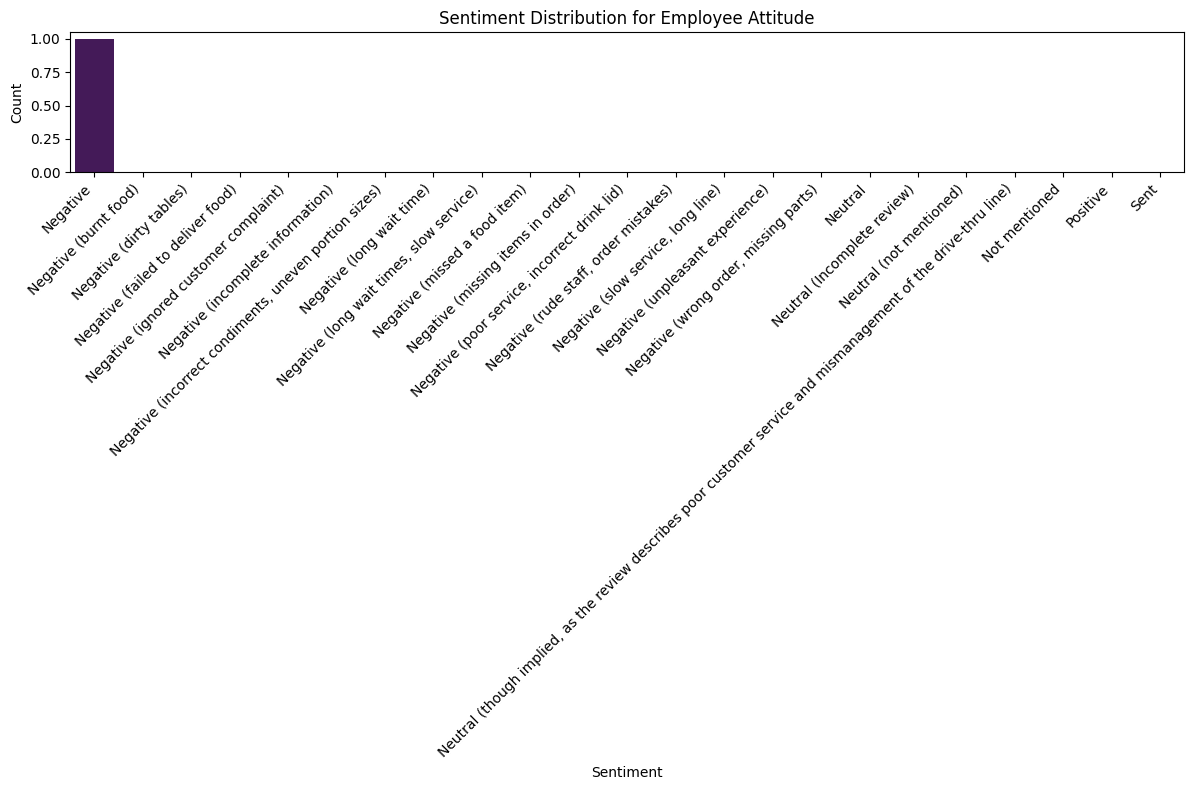

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


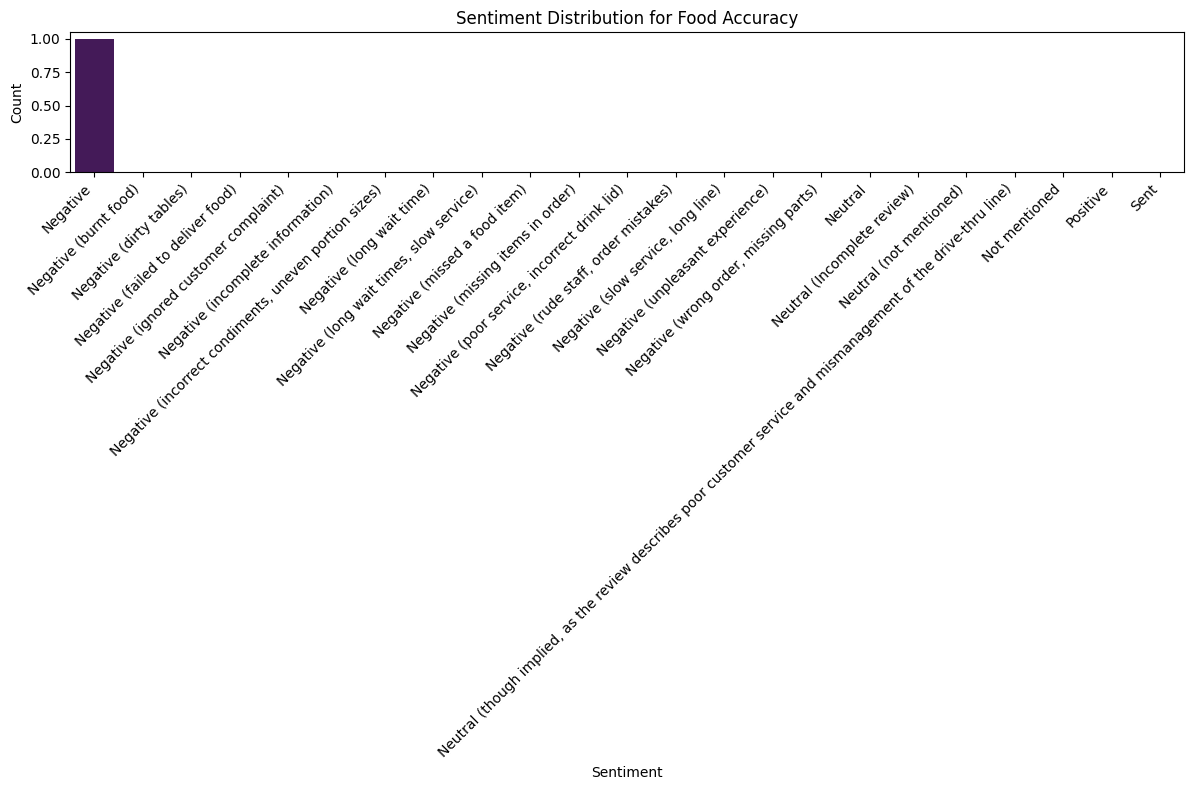

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


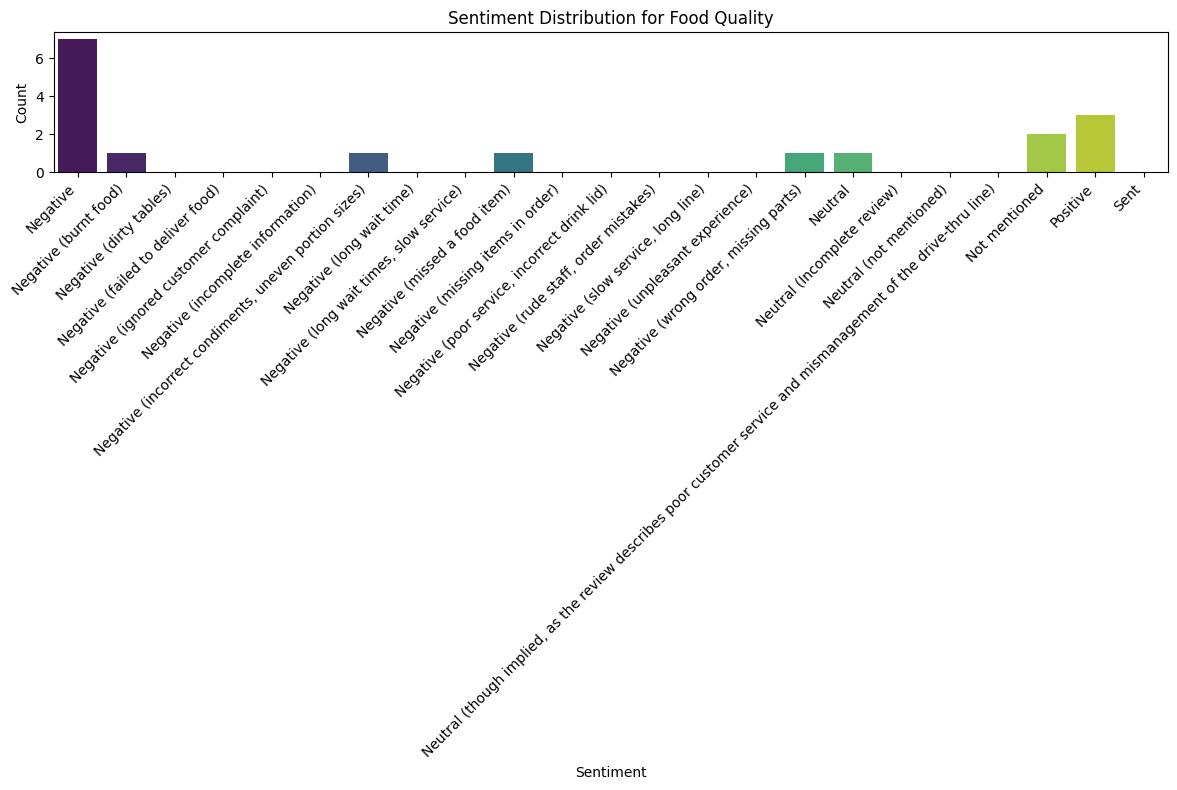

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


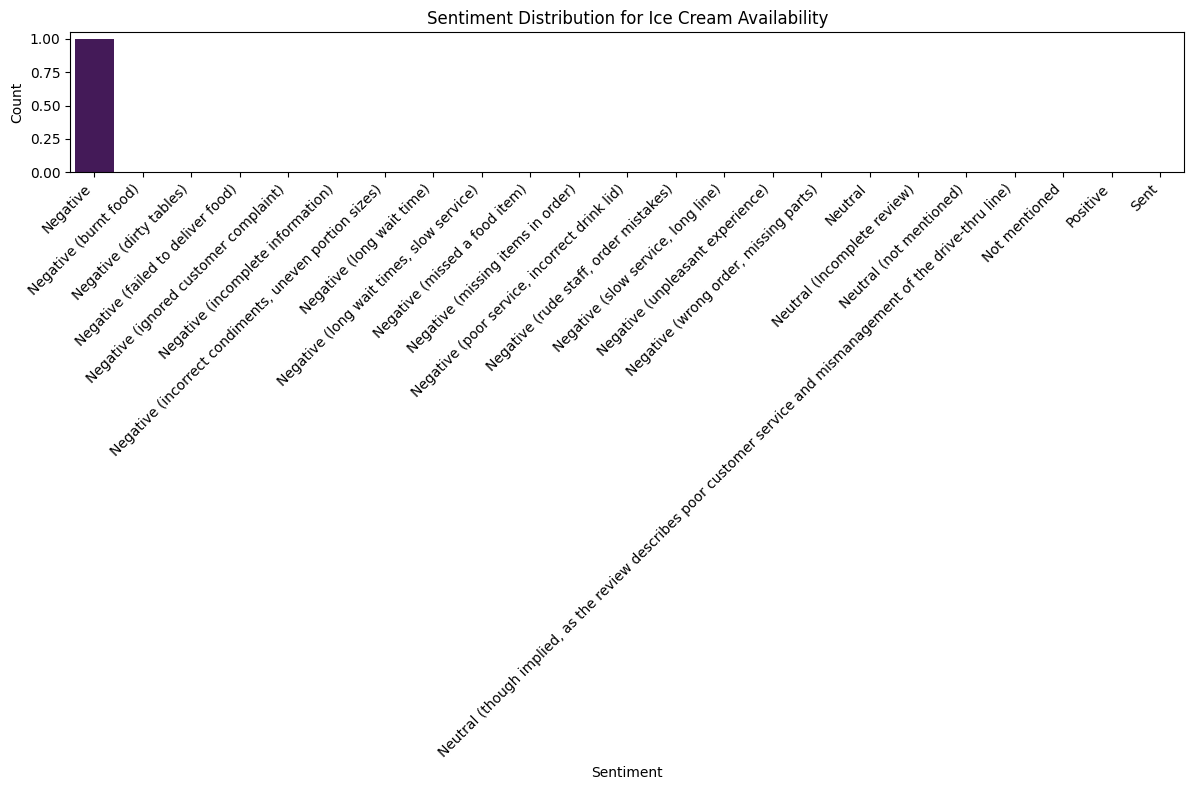

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


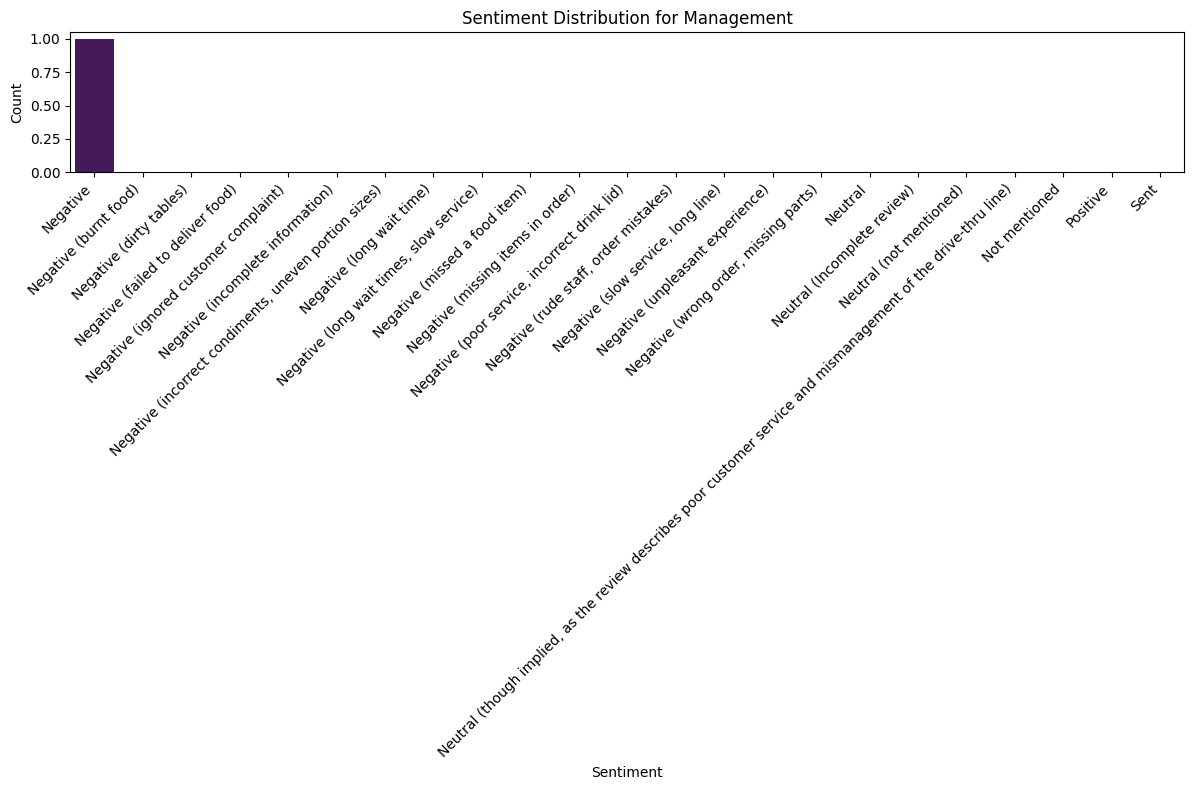

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


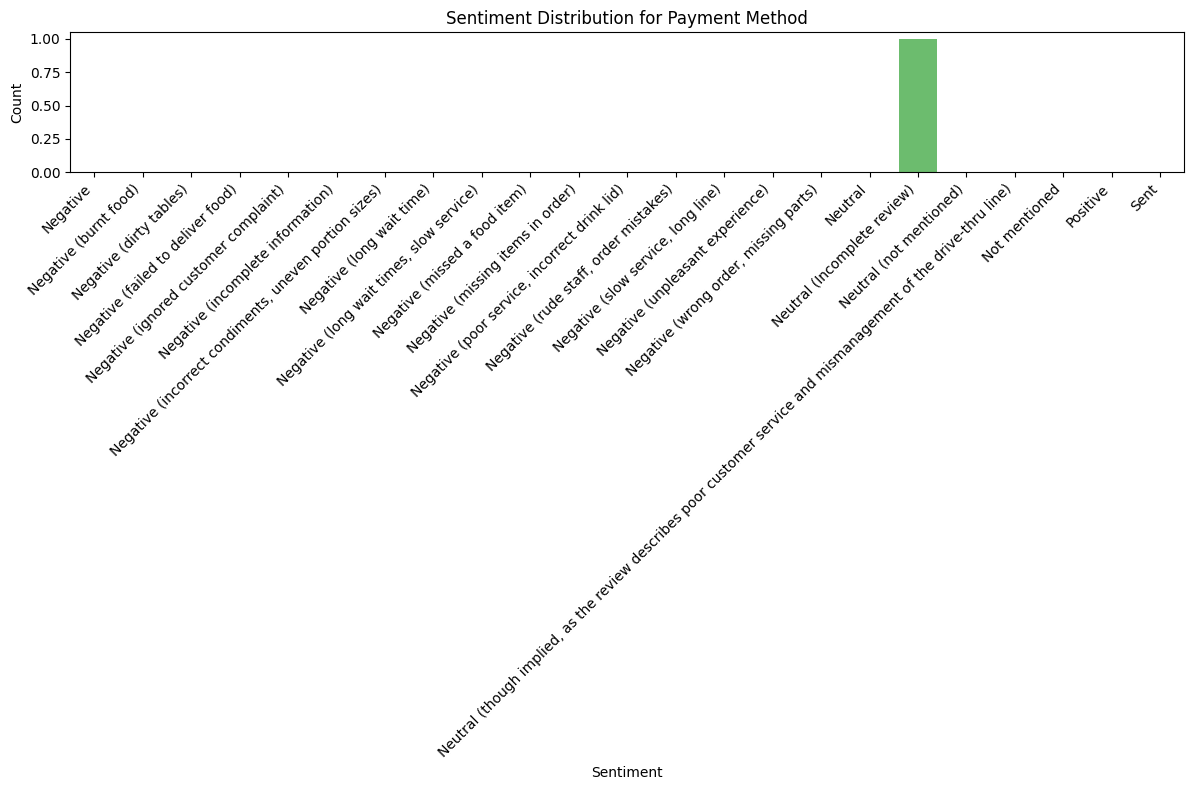

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


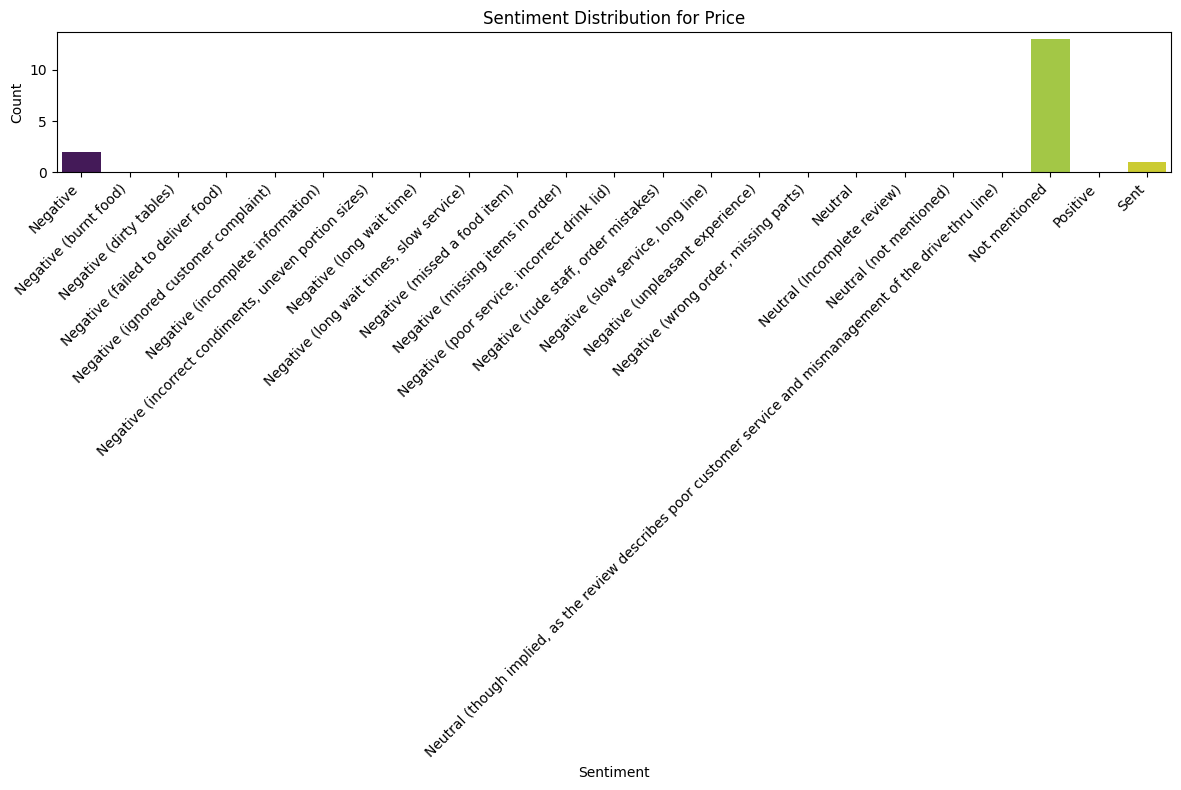

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


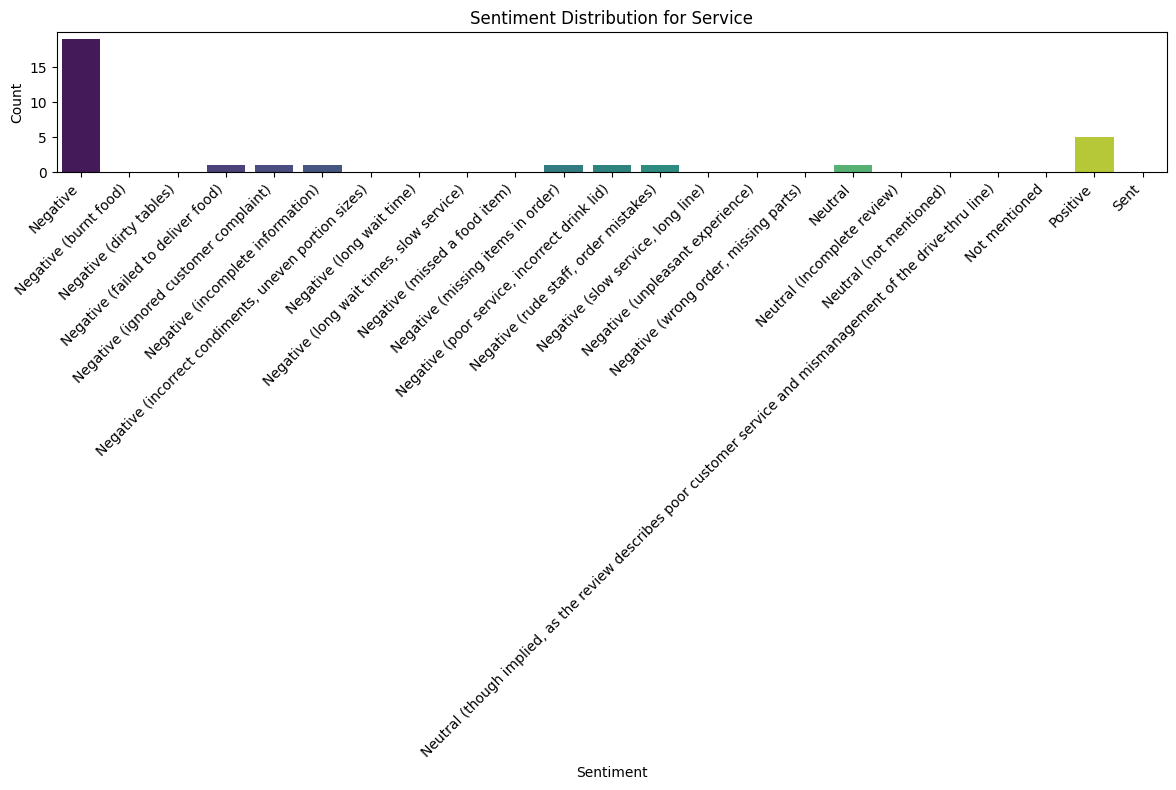

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


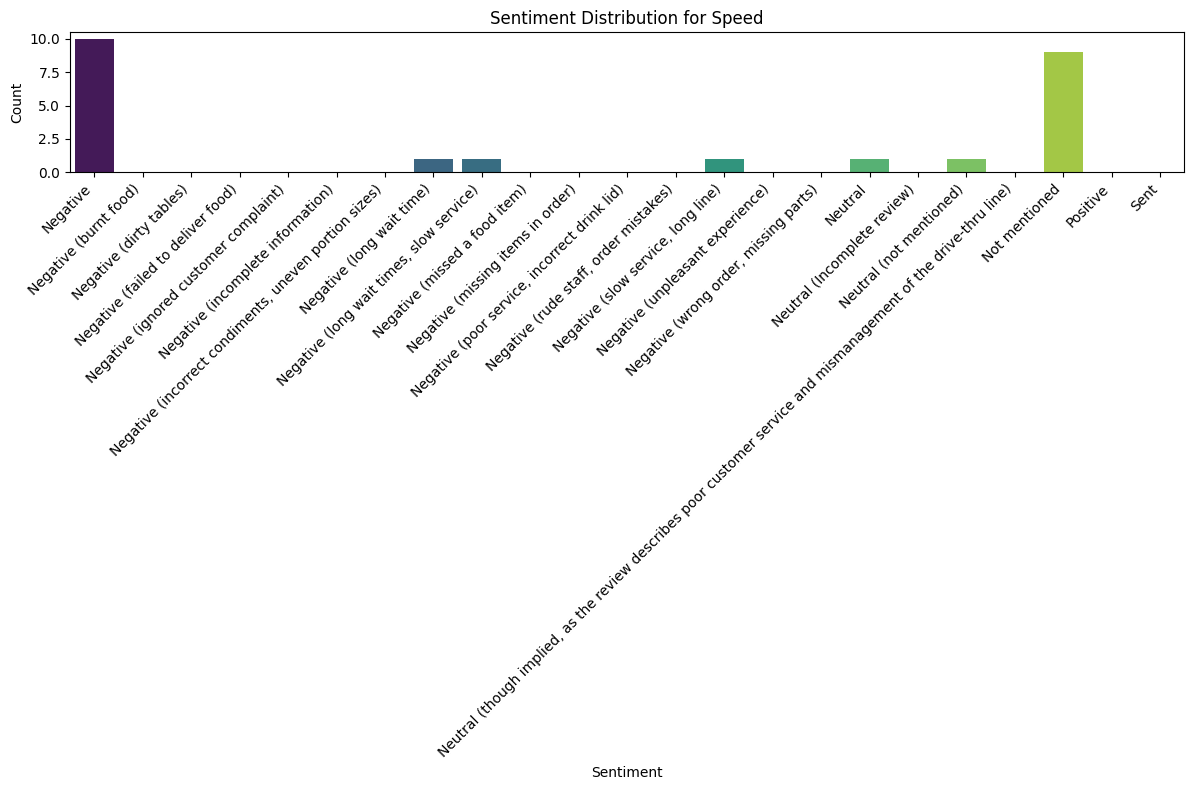

/tmp/ipython-input-2515805759.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


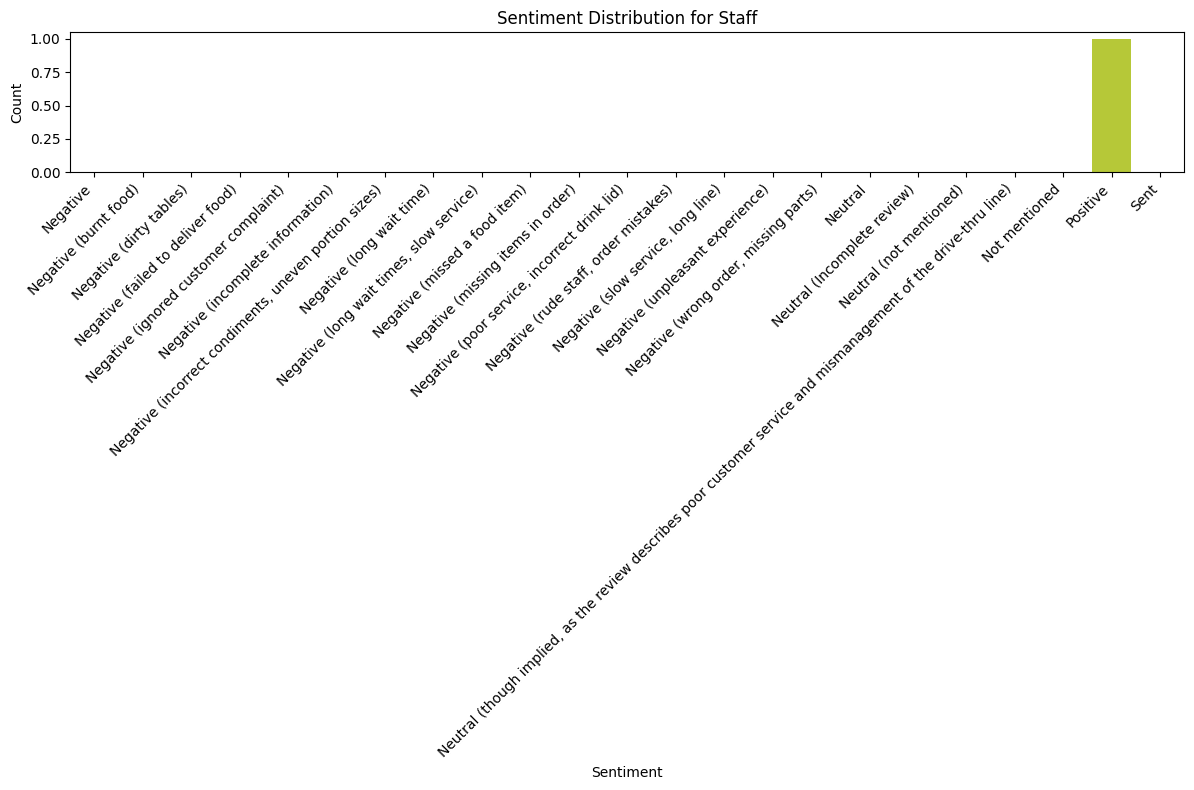

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

for index, row in sentiment_distribution.iterrows():
    aspect = index
    sentiment_counts = row

    plt.figure(figsize=(12, 8)) # Increased figure size
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.title(f'Sentiment Distribution for {aspect}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Save the figure to a file
    plt.savefig(f'{aspect}_sentiment_distribution.png')
    plt.show()